In [1]:
# Predict intervals (info) from chord label

In [1]:
# Libraries
import sys
sys.path.insert(0, '../../src')
import harmoutil

import numpy as np

from keras.models import Model
from keras.layers import Input, Dense

import tensorflow as tf

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Create individual chord and melody element lists 
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
# data = [section for section in data if not check_if_augmented_major(section)]
# print("---Remove sections with augmented major chord---")
# print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# print(sum([len(section) for section in chords_by_sections]))
print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))

Number of sections: 28884 | Sample section chords: ['E6', 'Db7', 'Gb-7', 'B7', 'E', 'Db-7', 'Gb-7', 'B7', 'B-7', 'E7', 'A7', 'D7', 'Ab-7', 'Db7', 'Gb-7', 'B7']
Number of chords: 334344 | Sample chord: E6
Number of melodies 334344 | Sample melody: [4, 4]
Number of melody notes in the data: 2209944 | Sample melody note: 4


In [4]:
# Keep only relevant data (chords with melody and non-NC chords)
relevant_chords = []
# for i, ch in enumerate(chords):
#     if (ch != 'NC'):
#         relevant_chords.append(ch)

for i, (ch, mel) in enumerate(zip(chords, notes_by_chords)):
    if (ch != 'NC') and (not list(set(mel)) == [-1]):
        relevant_chords.append(ch)
#         relevant_melody.append([n for n in mel if n != -1])
        
        
unique_chords = list(sorted(list(set(relevant_chords))))
print(len(unique_chords))

192


In [5]:
# Prepare the data
suffixes = [harmoutil.split_root_suffix(ch)[1] for ch in relevant_chords]
unique_suffixes = list(sorted(list(set(suffixes))))

intervals = [harmoutil.root_position(sf) for sf in suffixes]
print(len(relevant_chords), len(intervals))

311064 311064


In [6]:
for i in range(10):
    print(relevant_chords[i], intervals[i])

E6 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Db-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Gb-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
B7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
B-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
E7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
A7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
D7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Ab-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Db7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]


In [7]:
# Create categorical data mappings

# Note to integer index
# pitch_to_int = dict([(c, i) for i, c in enumerate(sorted(pitches))])
# print("Melody note to integer mapping:\n {}\n".format(pitch_to_int))

# Integer to note
# int_to_pitch = dict([(k, v) for v, k in pitch_to_int.items()])
# print("Integer to melody note mapping:\n {}\n".format(int_to_pitch))

# Chord to integer index
chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
# chord_to_int['<bos>'] = len(chord_to_int)
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))

# Integer to chord index
int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Chord label to integer mapping:
 {'A': 0, 'A+': 1, 'A+7': 2, 'A+j7': 3, 'A-': 4, 'A-6': 5, 'A-7': 6, 'A-j7': 7, 'A6': 8, 'A7': 9, 'Ab': 10, 'Ab+': 11, 'Ab+7': 12, 'Ab+j7': 13, 'Ab-': 14, 'Ab-6': 15, 'Ab-7': 16, 'Ab-j7': 17, 'Ab6': 18, 'Ab7': 19, 'Abj7': 20, 'Abm7b5': 21, 'Abo': 22, 'Abo7': 23, 'Absus': 24, 'Absus7': 25, 'Aj7': 26, 'Am7b5': 27, 'Ao': 28, 'Ao7': 29, 'Asus': 30, 'Asus7': 31, 'B': 32, 'B+': 33, 'B+7': 34, 'B+j7': 35, 'B-': 36, 'B-6': 37, 'B-7': 38, 'B-j7': 39, 'B6': 40, 'B7': 41, 'Bb': 42, 'Bb+': 43, 'Bb+7': 44, 'Bb+j7': 45, 'Bb-': 46, 'Bb-6': 47, 'Bb-7': 48, 'Bb-j7': 49, 'Bb6': 50, 'Bb7': 51, 'Bbj7': 52, 'Bbm7b5': 53, 'Bbo': 54, 'Bbo7': 55, 'Bbsus': 56, 'Bbsus7': 57, 'Bj7': 58, 'Bm7b5': 59, 'Bo': 60, 'Bo7': 61, 'Bsus': 62, 'Bsus7': 63, 'C': 64, 'C+': 65, 'C+7': 66, 'C+j7': 67, 'C-': 68, 'C-6': 69, 'C-7': 70, 'C-j7': 71, 'C6': 72, 'C7': 73, 'Cj7': 74, 'Cm7b5': 75, 'Co': 76, 'Co7': 77, 'Csus': 78, 'Csus7': 79, 'D': 80, 'D+': 81, 'D+7': 82, 'D+j7': 83, 'D-': 84, 'D-6': 85, '

In [8]:
# Define numerical variables

n_samples = len(relevant_chords)
n_intervals = 12
n_chords = len(chord_to_int)
n_dimensions = 16


print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_intervals))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of dimensions in embedding vectors: {}".format(n_dimensions))

Total number of samples: 311064
Number of distinct melody notes: 12
Number of distinct chord labels: 192
Number of dimensions in embedding vectors: 16


In [9]:
# Prepare tensors
X = np.zeros((n_samples, n_chords), dtype='float32')
Y = np.zeros((n_samples, n_intervals), dtype='float32')

for i, (ch, pos) in enumerate(zip(relevant_chords, intervals)):
    X[i, chord_to_int[ch]] = 1
    for j, pitch_presence in enumerate(pos):
        Y[i, j] = pitch_presence

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192)               0         
_________________________________________________________________
embeddings (Dense)           (None, 16)                3088      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
Total params: 3,292
Trainable params: 3,292
Non-trainable params: 0
_________________________________________________________________
None


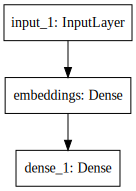

In [10]:
# Build model (Keras)

input_layer = Input(shape=(n_chords,)) # (n_samples * n_chords)
embeddings_layer = Dense(n_dimensions, activation='linear', name="embeddings")(input_layer) # in:(n_samples * n_chords) . hid:(n_chords * n_dimensions) = out:(n_samples * n_dimensions)
output_layer = Dense(n_intervals, activation='sigmoid')(embeddings_layer) # in:(n_samples * n_dimensions) . hid:(n_dimensions * n_roots) = out:(n_samples * n_roots)

model = Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
# Train model
batch_size = 32
epochs = 5

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size)

Epoch 1/5
311064/311064 [==============================] - 19s 60us/step - loss: 0.0295 - acc: 0.9911
Epoch 2/5
311064/311064 [==============================] - 18s 59us/step - loss: 7.4066e-05 - acc: 1.0000
Epoch 3/5
311064/311064 [==============================] - 18s 59us/step - loss: 2.0892e-06 - acc: 1.0000
Epoch 4/5
311064/311064 [==============================] - 20s 63us/step - loss: 1.9601e-07 - acc: 1.0000
Epoch 5/5
311064/311064 [==============================] - 23s 73us/step - loss: 1.2272e-07 - acc: 1.0000


In [12]:
# Retrieve embedding weights
embeddings_X = model.layers[1].get_weights()[0]
print(embeddings_X.shape)

(192, 16)


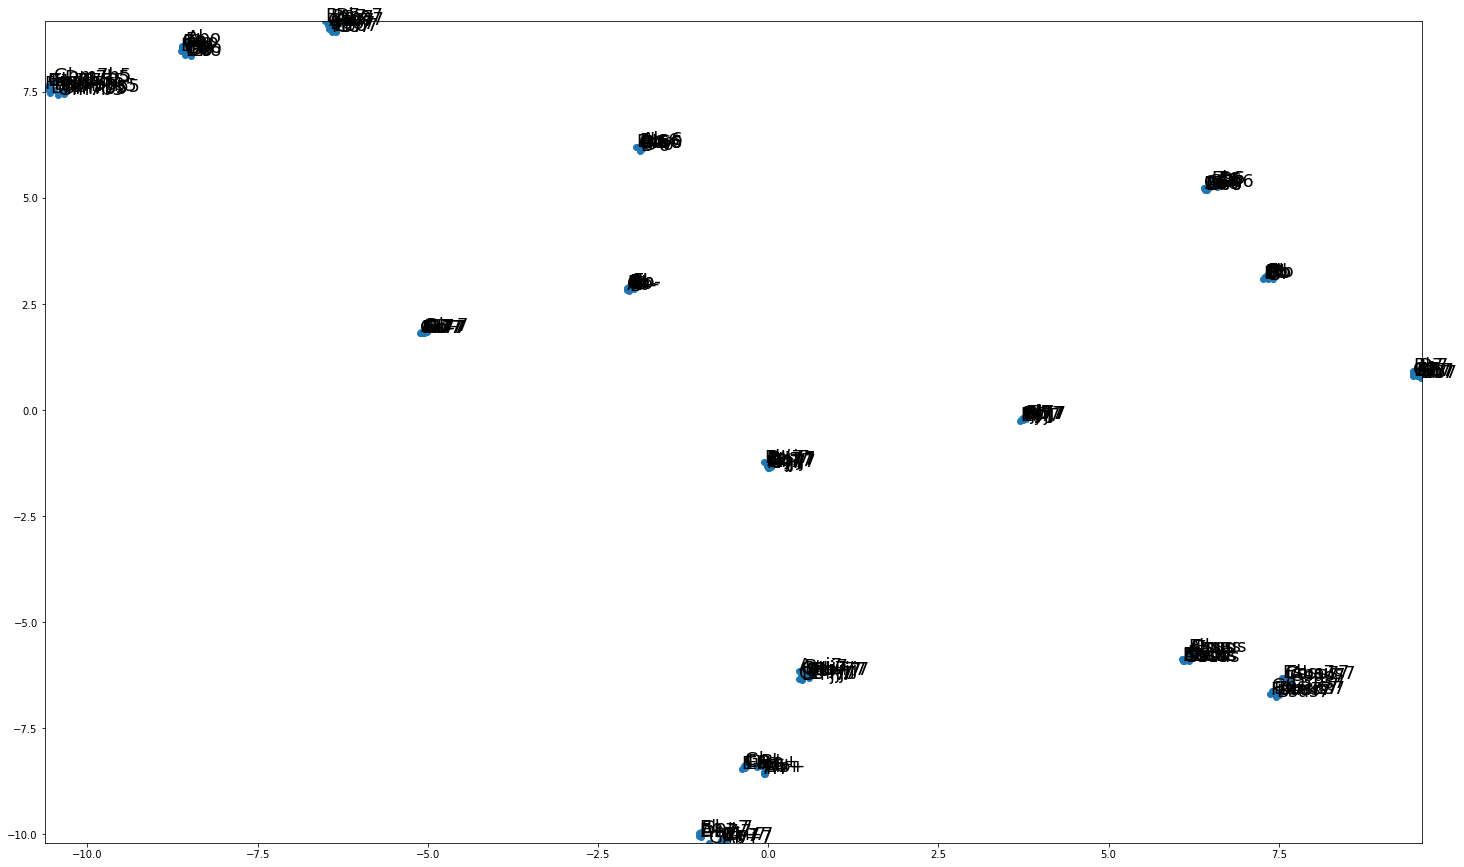

In [13]:
# Train t-SNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
embeddings_Y = tsne.fit_transform(embeddings_X)

x_coords = embeddings_Y[:, 0]
y_coords = embeddings_Y[:, 1]
# display scatter plot
plt.figure(figsize=(20,12))
plt.scatter(x_coords, y_coords)

for label, x, y in zip(unique_chords, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=18)
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.tight_layout()#rect=[-0.1, 0, 1, 1])
plt.savefig('intervals_tsne.eps', format='eps')
plt.show()

In [14]:
# Reorder embeddings and labels
def reorder_labels_and_embeddings(labels, embeddings):
    notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
    re_labels = []
    re_embeddings = []
    for note in notes:
        for lab, emb in zip(labels, embeddings):                
            rt, sf = harmoutil.split_root_suffix(lab) 
            if (note == rt):
                re_labels.append(lab)
                re_embeddings.append(emb)                
    return re_labels, re_embeddings
        
reordered_labels, reordered_embeddings = reorder_labels_and_embeddings(unique_chords, embeddings_X)

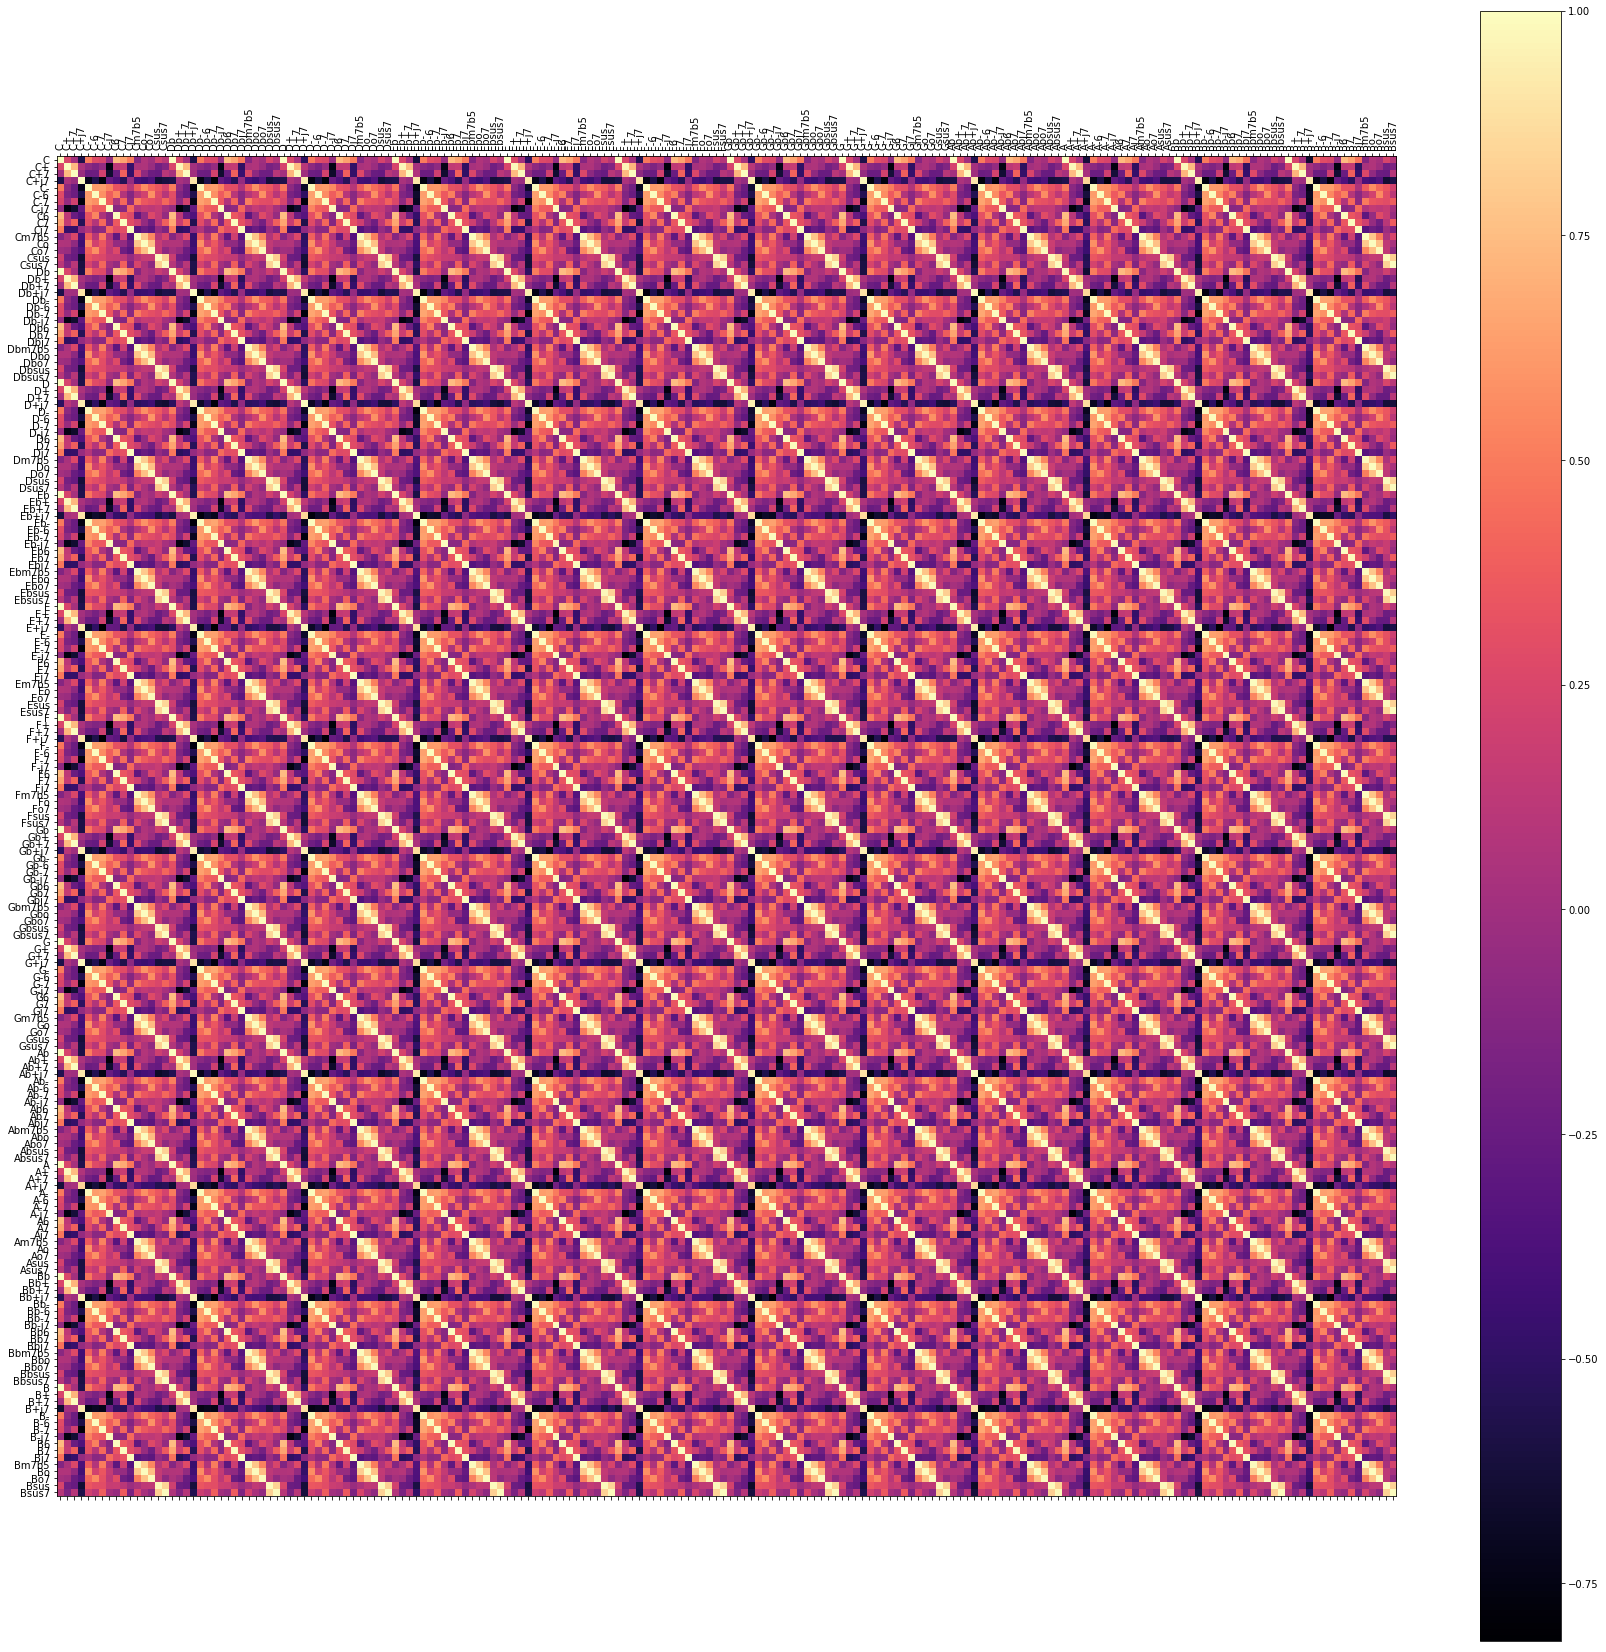

In [15]:
# Compute distance matrix

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

distance_matrix = np.zeros((len(reordered_labels), len(reordered_labels)), dtype='float32')
for i, vec1 in enumerate(reordered_embeddings):
    for j, vec2 in enumerate(reordered_embeddings):
#         distance_matrix[i, j] = -np.linalg.norm(vec2-vec1)
        distance_matrix[i, j] = cosine_similarity(vec1, vec2)


plt.figure(figsize=(30,30))              
ax = plt.axes()                 
im = ax.matshow(distance_matrix, cmap='magma')      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(unique_chords)), reordered_labels, rotation='vertical')
plt.yticks(np.arange(len(unique_chords)), reordered_labels)
plt.show()


In [16]:
# Reorder embeddings and labels
def reorder_labels_and_embeddings(labels, embeddings):
#     notes = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
    suffix_list = list(set(unique_suffixes))
    re_labels = []
    re_embeddings = []
    for suff in suffix_list:
        for lab, emb in zip(labels, embeddings):                
            rt, sf = harmoutil.split_root_suffix(lab) 
            if (suff == sf):
                re_labels.append(lab)
                re_embeddings.append(emb)                
    return re_labels, re_embeddings
        
reordered_labels, reordered_embeddings = reorder_labels_and_embeddings(unique_chords, embeddings_X)

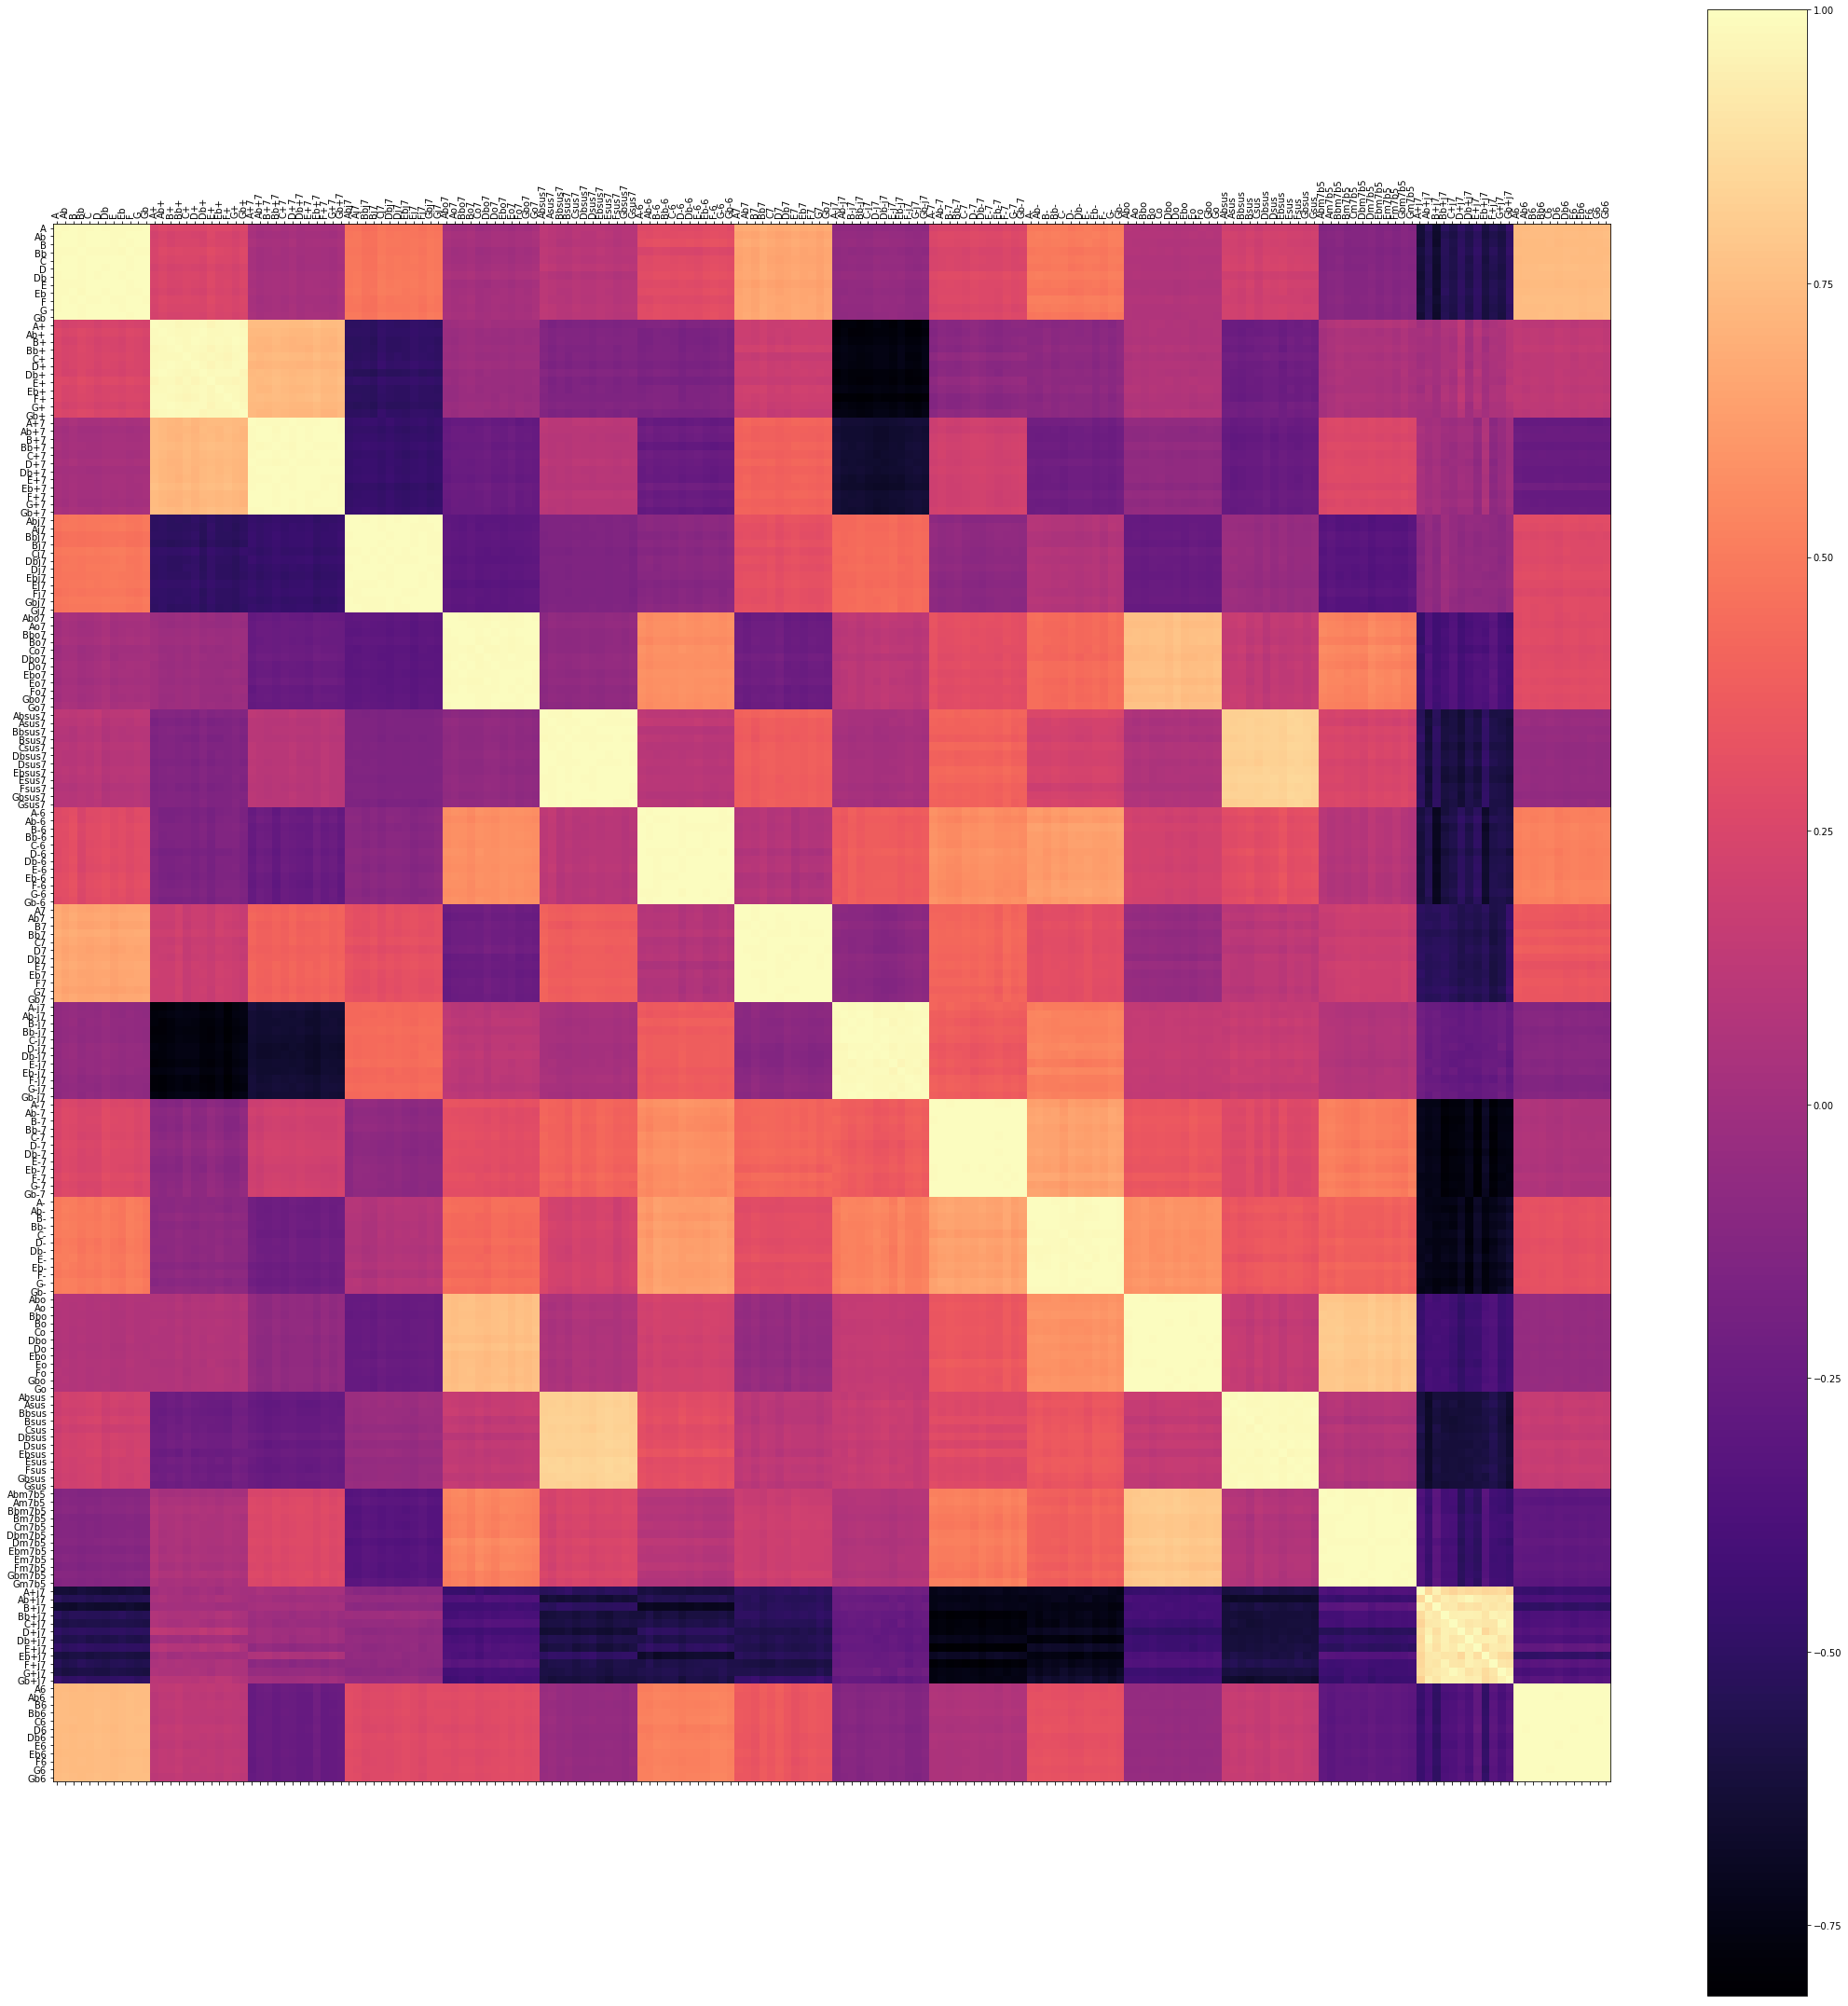

In [17]:
# Compute distance matrix

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

distance_matrix = np.zeros((len(reordered_labels), len(reordered_labels)), dtype='float32')
for i, vec1 in enumerate(reordered_embeddings):
    for j, vec2 in enumerate(reordered_embeddings):
        distance_matrix[i, j] = cosine_similarity(vec1, vec2)



plt.figure(figsize=(30,30))              
ax = plt.axes()                 
im = ax.matshow(distance_matrix, cmap='magma')      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(unique_chords)), reordered_labels, rotation='vertical')
plt.yticks(np.arange(len(unique_chords)), reordered_labels)
plt.tight_layout()#rect=[-0.1, 0, 1, 1])
plt.savefig('intervals_cosine.eps', format='eps')
plt.show()


In [27]:
# Save the embeddings
model.save_weights("weights/interval_weights.h5")